# Contour Interpolation Notes
The current interpolation method for polygons is linear interpolation. This means that the contour lines are drawn by connecting points that are linearly interpolated between the data points. This method is simple and efficient, but it can lead to jagged or non-smooth contour lines, especially in areas with rapid changes in data values or rotated polygons.

However, it is good enough for most cases, and will be used for the time being. 

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import shapely

from types_and_classes import SliceIndexSequenceType


### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

### Create interpolated slices as needed for each contour graph
1. Find all slice indexes that are not original
2. For each slice index:
    1. use contour_lookup to determine if that slice exists in the contour graph.'
    2. If it does not exist, but the previous and next slices do, and have the same region index:
        1. create an interpolated contour at the specified index.
        2. set the IsInterpolated attribute to True.
        3. set the region index to the region index of the previous slice.
        4. set the IsBoundary attribute to False
        4. add the interpolated contour to the contour graph.
        5. Add edges to the contour graph between the interpolated contour and the previous and next slices.


In [4]:
def calculate_new_slice_index(slices: SliceIndexSequenceType,
                              precision=PRECISION) -> float:
    '''Calculate the new z value based on the given slices.

    Args:
        slices (Union[List[SliceIndexType], SliceIndexType]): The slices to
            calculate the new z value from.

    Returns:
        float: The calculated new z value.
    '''
    if isinstance(slices, (list, tuple)):
        new_slice = round(np.mean(slices), precision)
        min_slice = round(min(slices), precision)
        max_slice = round(max(slices), precision)
        if not (min_slice <= new_slice <= max_slice):
            raise ValueError("Calculated slice is out of bounds after rounding.")
        return new_slice
    else:
        return slices


In [5]:
def interpolate_polygon(slices: SliceIndexSequenceType, p1: shapely.Polygon,
                        p2: shapely.Polygon = None) -> shapely.Polygon:
    '''Interpolate a polygon between two polygons based on the given slices.

    This function takes two polygons and interpolates a new polygon based on
    the given slices. The new polygon is created by interpolating the
    coordinates of the two polygons,

    **any holes of the first polygon are also interpolated.**

    The new polygon is then assigned a z value based on the given slices.
    The function also handles the case where one of the polygons
    is empty. The function raises a ValueError if either of the polygons are
    multi-polygons.
    The function also raises a ValueError if the first polygon is empty and no
    second polygon is given.
    Args:
        slices (SliceIndexSequenceType): _description_
        p1 (shapely.Polygon): _description_
        p2 (shapely.Polygon, optional): _description_. Defaults to None.

    Raises:
        ValueError: When either of the polygons are multi-polygons
        ValueError: When the first polygon is empty and no second polygon is
            given.
    Returns:
        shapely.Polygon: _description_
    '''
    # TODO Use shapely.affinity.scale to interpolate polygons
    def align_polygons(p1, p2):
        # Get the point between the centroid of the first and second polygons.
        cm_shift = ((p2.centroid.x - p1.centroid.x) / 2,
                    (p2.centroid.y - p1.centroid.y) / 2)
        # Shift the two polygons to the same mid point.
        ctr_poly1 = shapely.affinity.translate(p1,
                                               xoff=cm_shift[0],
                                               yoff=cm_shift[1])
        ctr_poly2 = shapely.affinity.translate(p2,
                                               xoff=-cm_shift[0],
                                               yoff=-cm_shift[1])
        # get the scaling factors for the two polygons.
        x_size1 = p1.bounds[2] - p1.bounds[0]
        y_size1 = p1.bounds[3] - p1.bounds[1]
        x_size2 = p2.bounds[2] - p2.bounds[0]
        y_size2 = p2.bounds[3] - p2.bounds[1]
        scale_x1 = (x_size1 + x_size2) /( 2 * x_size1)
        scale_y1 = (y_size1 + y_size2) /( 2 * y_size1)
        scale_x2 = (x_size1 + x_size2) /( 2 * x_size2)
        scale_y2 = (y_size1 + y_size2) /( 2 * y_size2)
        scale_poly1 = shapely.affinity.scale(ctr_poly1,
                                             xfact=scale_x1,
                                             yfact=scale_y1)
        scale_poly2 = shapely.affinity.scale(ctr_poly2,
                                             xfact=scale_x2,
                                             yfact=scale_y2)
        return scale_poly1, scale_poly2

    def match_holes(p1, p2):
        if p1.is_empty:
            holes1 = []
        else:
            holes1 = list(p1.interiors)
        # If no second polygon given, use the centroid of each first hole as the
        # matching second hole boundary.
        if p2 is None:
            if holes1:
                matched_holes = [(hole, hole.centroid) for hole in holes1]
            else:
                matched_holes = []
            return matched_holes
        # If the first polygon does not have any holes, and the second polygon
        # does, use the centroid of the second hole as the matching first hole
        # boundary.
        holes2 =  list(p2.interiors)
        if not holes1:
            matched_holes = [(hole, hole.centroid) for hole in holes2]
            return matched_holes
        # If both polygons have holes, match the holes match the holes of the
        # second polygon to the first polygon.
        matched_holes = []
        # set each second hole as not matched.
        hole2_matched = {i: False for i in range(len(holes2))}
        for hole1 in holes1:
            matched1 = False  # set the first hole as not matched.
            for idx, hole2 in enumerate(holes2):
                if hole1.overlaps(hole2):
                    matched_holes.append((hole1, hole2))
                    matched1 = True # set the first hole as matched.
                    hole2_matched[idx] = True  # set the second hole as matched.
            # If the first hole is not matched, use the centroid of the first
            # hole as the matching second hole boundary.
            if not matched1:
                matched_holes.append((hole1, hole1.centroid))
        # Add any unmatched holes from the second polygon, using the centroid of
        # the second hole as the matching first hole boundary.
        for idx, hole2 in enumerate(holes2):
            if not hole2_matched[idx]:
                matched_holes.append((hole2, hole2.centroid))
        return matched_holes

    def interpolate_boundaries(boundary1, boundary2):
        new_cords = []
        for crd in boundary1.coords:
            ln = shapely.shortest_line(shapely.Point(crd), boundary2)
            ptn = ln.interpolate(0.5, normalized=True)
            new_cords.append(ptn)
        return new_cords

    # Get the z value for the new polygon.
    new_z = calculate_new_slice_index(slices)
    # Error Checking
    # If either of the polygons are multi-polygons, raise an error.
    if isinstance(p1, shapely.MultiPolygon):
        raise ValueError('Only single polygons are supported.')
    if isinstance(p2, shapely.MultiPolygon):
        raise ValueError('Only single polygons are supported.')
    # Cannot interpolate two empty polygons.
    if p1.is_empty & (p2 is None):
        raise ValueError('No second polygon given and first polygon is empty.')

    # If only one polygon is given, scale the polygon to half its size.
    if p2 is None:
        itp_poly = shapely.affinity.scale(p1, xfact=0.5, yfact=0.5)
        itp_poly = shapely.force_3d(itp_poly, new_z)
        return itp_poly
    elif p1.is_empty:
        itp_poly = shapely.affinity.scale(p2, xfact=0.5, yfact=0.5)
        itp_poly = shapely.force_3d(itp_poly, new_z)
        return itp_poly

    # If two polygons given, align the polygons to the same center and size and
    # then adjust the shape using a linear interpolation to the half way point
    # between the two polygons.
    # Align and scale the polygons to the same centre and size.
    aligned_poly1, aligned_poly2 = align_polygons(p1, p2)
    # Interpolate the new polygon coordinates as half way between the p1
    # boundary and boundary 2.
    boundary1 = aligned_poly1.exterior
    boundary2 = aligned_poly2.exterior
    new_cords = interpolate_boundaries(boundary1, boundary2)
    # Add the holes to the new polygon.
    new_holes = []
    matched_holes = match_holes(p1, p2)
    for hole1, hole2 in matched_holes:
        new_hole = interpolate_boundaries(hole1, hole2)
        new_holes.append(new_hole)
    # Build the new polygon from the interpolated coordinates.
    itp_poly = shapely.Polygon(new_cords, holes=new_holes)
    # Add the z value to the polygon.
    itp_poly = shapely.force_3d(itp_poly, new_z)
    return itp_poly


# Algorithm options for interpolating polygons
- need to translate and scale the polygons before interpolating the coordinates otherwise there is a possibility that the coordinate pairs selected from the two polygons will not be correct when there is a significant difference in the size or position of the two polygons.

For the translation, use the difference between the centres of the two polygons:
> $\Delta_x =  \frac{(x2_c - x1_c)}{2}$<br><br>
> $\Delta_y =  \frac{(y2_c - y1_c)}{2}$<br><br>

For the scaling, use the ratio of the x and y bounds of the two polygons:
> $Size_{x1} = bounds(P_1)_{+x} - bounds(P_1)_{-x}$<br>
> $Size_{y1} = bounds(P_1)_{+y} - bounds(P_1)_{-y}$<br><br>
> $\Gamma_{x1} = \frac{Size_{x1}+Size_{x2}}{2 \times Size_{x1}}$<br><br>
> $\Gamma_{y1} = \frac{Size_{y1}+Size_{y2}}{2 \times Size_{y1}}$<br><br>
> $P_1' = P_1 \times (\Gamma_{x1}, \Gamma_{y1})$<br>

In [6]:
def align_polygons(p1, p2):
    # Get the point between the centroid of the first and second polygons.
    cm_shift = ((p2.centroid.x - p1.centroid.x) / 2,
                (p2.centroid.y - p1.centroid.y) / 2)
    # Shift the two polygons to the same mid point.
    ctr_poly1 = shapely.affinity.translate(p1,
                                            xoff=cm_shift[0],
                                            yoff=cm_shift[1])
    ctr_poly2 = shapely.affinity.translate(p2,
                                            xoff=-cm_shift[0],
                                            yoff=-cm_shift[1])
    # get the scaling factors for the two polygons.
    x_size1 = p1.bounds[2] - p1.bounds[0]
    y_size1 = p1.bounds[3] - p1.bounds[1]
    x_size2 = p2.bounds[2] - p2.bounds[0]
    y_size2 = p2.bounds[3] - p2.bounds[1]
    scale_x1 = (x_size1 + x_size2) /( 2 * x_size1)
    scale_y1 = (y_size1 + y_size2) /( 2 * y_size1)
    scale_x2 = (x_size1 + x_size2) /( 2 * x_size2)
    scale_y2 = (y_size1 + y_size2) /( 2 * y_size2)
    scale_poly1 = shapely.affinity.scale(ctr_poly1,
                                            xfact=scale_x1,
                                            yfact=scale_y1)
    scale_poly2 = shapely.affinity.scale(ctr_poly2,
                                            xfact=scale_x2,
                                            yfact=scale_y2)
    return scale_poly1, scale_poly2

[(-0.5, -0.5, 0.5), (1.5, -0.5, 0.5), (1.5, 1.5, 0.5), (-0.5, 1.5, 0.5), (-0.5, -0.5, 0.5)]
(-1.0, -1.0, 1.0, 1.0)
(0.0, 0.0, 2.0, 2.0)
(-0.5, -0.5, 1.5, 1.5)
4.0
4.0
4.0


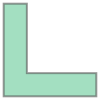

In [7]:
p1 = Polygon([(-1.0, -1.0), (1.0, -1.0), (1.0, 1.0), (-1.0, 1.0)])
p2 = Polygon([(0.0, 0.0), (2.0, 0.0), (2.0, 2.0), (0.0, 2.0)])
interpolated = interpolate_polygon([0, 1], p1, p2)
print(list(interpolated.boundary.coords))
print(p1.bounds)
print(p2.bounds)
print(interpolated.bounds)
print(p1.area)
print(p2.area)
print(interpolated.area)
p1 - interpolated

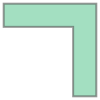

In [8]:
p2 - interpolated

[(-1.0, -1.0, 0.5), (1.0, -1.0, 0.5), (1.0, 1.0, 0.5), (-1.0, 1.0, 0.5), (-1.0, -1.0, 0.5)]
(-0.5, -0.5, 0.5, 0.5)
(-1.5, -1.5, 1.5, 1.5)
(-1.0, -1.0, 1.0, 1.0)
1.0
9.0
4.0
POINT (0 0)
POINT (0 0)
POINT (0 0)


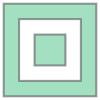

In [9]:
p1 = Polygon([(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)])
p2 = Polygon([(-1.5, -1.5), (1.5, -1.5), (1.5, 1.5), (-1.5, 1.5)])
interpolated = interpolate_polygon([0, 1], p1, p2)
print(list(interpolated.boundary.coords))
print(p1.bounds)
print(p2.bounds)
print(interpolated.bounds)
print(p1.area)
print(p2.area)
print(interpolated.area)
print(p1.centroid)
print(p2.centroid)
print(interpolated.centroid)
shapely.union(p2 - interpolated, p1)

[(0.0, 0.0, 0.5), (1.0, 0.0, 0.5), (1.0, 1.0, 0.5), (0.0, 1.0, 0.5), (0.0, 0.0, 0.5)]
(-0.5, -0.5, 0.5, 0.5)
(0.5, 0.5, 1.5, 1.5)
(0.0, 0.0, 1.0, 1.0)
1.0
1.0
1.0
POINT (0 0)
POINT (1 1)
POINT (0.5 0.5)


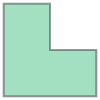

In [10]:
p1 = Polygon([(-0.5, -0.5), (0.5, -0.5), (0.5, 0.5), (-0.5, 0.5)])
p2 = Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])
interpolated = interpolate_polygon([0, 1], p1, p2)
print(list(interpolated.boundary.coords))
print(p1.bounds)
print(p2.bounds)
print(interpolated.bounds)
print(p1.area)
print(p2.area)
print(interpolated.area)
print(p1.centroid)
print(p2.centroid)
print(interpolated.centroid)
p1 - interpolated

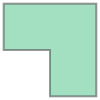

In [11]:
p2 - interpolated

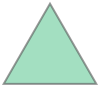

In [12]:
triangle = Polygon([
    (0, 1 / (3**0.5)),  # Top vertex
    (-0.5, -1 / (2 * (3**0.5))),  # Bottom-left vertex
    (0.5, -1 / (2 * (3**0.5)))  # Bottom-right vertex
    ])
triangle

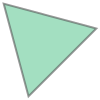

In [13]:
shapely.affinity.rotate(triangle, angle=45, origin='centroid')

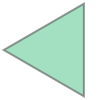

In [14]:
shapely.affinity.rotate(triangle, angle=90, origin='centroid')

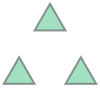

In [15]:
p1 = triangle
p2 = shapely.affinity.rotate(triangle, angle=60, origin='centroid')
p1-p2

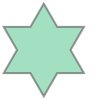

In [16]:
m = shapely.union(p1, p2)
m

In [17]:
print(p1.centroid)
print(p2.centroid)

POINT (0 0)
POINT (0 0)


In [18]:
interpolated = interpolate_polygon([0, 1], p1, p2)


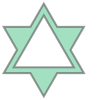

In [19]:
m - interpolated

In [20]:
aligned_poly1, aligned_poly2 = align_polygons(p1, p2)

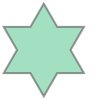

In [21]:
m = shapely.union(aligned_poly1, aligned_poly2)
m

In [22]:
boundary1 = aligned_poly1.exterior
boundary2 = aligned_poly2.exterior

In [23]:
list(boundary1.coords)

[(0.0, 0.5773502691896258),
 (-0.5, -0.2886751345948129),
 (0.5, -0.2886751345948129),
 (0.0, 0.5773502691896258)]

In [24]:
list(boundary2.coords)

[(-0.5, 0.2886751345948131),
 (-5.551115123125783e-17, -0.5773502691896258),
 (0.5, 0.28867513459481287),
 (-0.5, 0.2886751345948131)]

In [25]:
crd = boundary1.coords[0]
ln = shapely.shortest_line(shapely.Point(crd), boundary2)
list(ln.coords)

[(0.0, 0.5773502691896258), (-1.1102230246251565e-16, 0.288675134594813)]

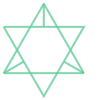

In [26]:
match_lines = []
for crd in boundary1.coords:
    ln = shapely.shortest_line(shapely.Point(crd), boundary2)
    match_lines.append(ln)

all_shapes = [boundary1, boundary2] + match_lines
m = shapely.union_all(all_shapes)
m

# Ideas from DeepSeek

**I have two polygons which represent axial cut-planes a specified distance apart through a 3D volume. I wish to generate an interpolated polygon half way between them. What is the best approach to use?**

Okay, so I need to figure out how to interpolate a polygon halfway between two existing polygons that are axial cut-planes through a 3D volume. Let me start by understanding the problem better.

First, these two polygons are slices taken at different positions along some axis, right? Let's say they're parallel to each other since they're axial cut-planes. The user wants a polygon that's halfway between them, probably in terms of position and shape. So interpolation here would mean creating a new polygon that's an average of the two original ones in some way.

But wait, polygons can be complex. They might not have the same number of vertices, and their shapes could differ. If the two original polygons are similar in shape and vertex count, interpolation might be straightforward. But if they're different, like one is a square and the other is a triangle, how do you interpolate between them? The user didn't specify whether the polygons are corresponding in structure, so I need to consider a general approach.

Hmm, maybe the first step is to ensure that both polygons have the same number of vertices. If they don't, I might need to resample one or both polygons to have matching vertex counts. For example, if one polygon has 4 vertices and the other has 5, I could add a vertex along a side of the 4-sided polygon to make it 5. But how to decide where to add the vertex? Maybe by parameterizing the perimeter and inserting points at appropriate intervals.


Another approach is to use shape interpolation techniques. I remember that morphing between two shapes often involves establishing correspondences between points on the source and target shapes. If the polygons are not aligned or have different topologies, establishing these correspondences is crucial. But how to do that automatically?


Alternatively, maybe the problem assumes that the two polygons are aligned along the same axis and are cross-sections of a 3D volume. In medical imaging, for example, when you have slices of an organ, you might interpolate between them to create intermediate slices. In such cases, the shapes might be similar but not identical. Techniques used there might include shape-based interpolation or image-based interpolation.


Wait, the user mentioned "*axial cut-planes a specified distance apart through a 3D volume*." So perhaps these are cross-sectional slices, like in medical imaging or geological layers. The goal is to create an intermediate slice halfway between them. In such contexts, common methods include shape-based interpolation, where corresponding points between the two slices are determined, and then their positions are averaged.

But how do you handle different numbers of points? Let me think. Suppose Polygon $A$ has $N$ vertices and Polygon $B$ has $M$ vertices. To interpolate, you might need to resample both polygons to have the same number of vertices. For example, you can interpolate each polygon into $K$ points, where $K$ is the least common multiple of $N$ and $M$, or just choose a common number based on some criteria.


Alternatively, you can parameterize each polygon by their arc length. For each polygon, you can create a parameterization where each vertex is assigned a value between 0 and 1 based on its position along the perimeter. Then, you can resample both polygons to have the same number of points at corresponding parameter positions. For instance, if you choose $K$ points for both, each point at position $\frac{i}{K}$ along the perimeter. This way, even if the original polygons have different vertex counts, the resampled ones will have the same number, allowing for linear interpolation between corresponding points.


But this assumes that the polygons are parameterized in a compatible way. If one polygon is, say, a square and the other is a circle, just resampling them to the same number of points won't necessarily align corresponding features. So maybe correspondence is an issue here. The user didn't mention anything about correspondence, so perhaps the polygons are already aligned in some way, maybe as adjacent slices in a volume where features change gradually.

In that case, shape-based interpolation methods might work. One such method is to create a correspondence between the two polygons by finding a way to match vertices or points along their perimeters. This could be done by finding a common parameterization, like aligning the starting points and then matching points based on equal arc length fractions.

Once correspondence is established, linear interpolation of vertex positions would give the intermediate polygon. For example, if a vertex in Polygon $A$ is at $(x1, y1)$ and the corresponding vertex in Polygon $B$ is at $(x2, y2)$, the interpolated vertex would be at $((x1+x2)/2, (y1+y2)/2)$ if halfway.


But if the polygons are not convex, or have different topologies, this might not work. Another approach is to convert the polygons into implicit representations, like signed distance functions, and then interpolate those. For each polygon, compute a signed distance field on a grid, then average the two distance fields, and extract the zero level set as the interpolated polygon. This is more robust to topology changes and varying vertex counts but requires discretization and computational resources.

Alternatively, using the sweep or lofting operation, where you create a surface that transitions from one polygon to the other. The halfway polygon would be the cross-section of this lofted surface at the midpoint. However, lofting typically requires correspondence as well.

Another method is linear interpolation between corresponding points, but correspondence needs to be determined. If the polygons are slices of a 3D volume, perhaps there's a natural correspondence based on the structure of the volume. For instance, in voxel data, interpolating slices can be done via image interpolation, but here it's polygons, which are vector data.

Wait, maybe the best approach is to use the shape-based interpolation method as follows:

1. Resample both polygons to have the same number of points, uniformly distributed along their perimeters.

2. Align the polygons by finding a starting point correspondence (e.g., by minimizing some distance).

3. Interpolate each pair of corresponding points linearly.

But step 2 is crucial. If the starting points are not aligned, the interpolation might twist. For example, imagine two squares rotated relative to each other; interpolating vertex-wise without alignment would cause the intermediate square to twist. So, to avoid that, we need to find the optimal starting point alignment.


Alternatively, using dynamic time warping or some method to non-rigidly align the points. But that might be complex.


Another approach is to convert the polygons into a radial representation, where each point is represented by an angle and a radius from the centroid. Then, interpolating the radii at corresponding angles. But this works best for star-shaped polygons where the centroid is inside, and every radius from centroid intersects the polygon once.


Alternatively, using the Skeletal Animation approach, where you create a skeleton or medial axis between the two polygons and interpolate based on that. But that seems complicated.


Wait, the problem states that the polygons are "axial cut-planes" a specified distance apart. So maybe they are orthogonal to some axis, say the z-axis, and separated along z. So their x and y coordinates are in planes perpendicular to z. Then, the halfway polygon would be in the plane halfway along z between them.

In such a case, the problem reduces to interpolating the shapes in the x-y plane between the two z-positions. If the volume between the two planes is continuous, then the interpolation should represent the halfway cross-section.

In medical imaging, slice interpolation is a common problem. Methods include:

- Nearest neighbor: just copy the nearest slice, but that's not interpolation.

- Linear interpolation: for each pixel, interpolate between the two slices. But for vector polygons, this is more complex.

- Shape-based interpolation: align the two shapes, establish correspondence, interpolate vertices.

So for polygons, shape-based interpolation is likely the way to go. The steps would be:

1. Resample both polygons to have the same number of vertices, uniformly along their perimeters.

2. Align the polygons (rotation, starting point) to minimize distortion.

3. Interpolate corresponding vertices linearly.

But how to do the resampling and alignment?
First, resampling: to resample a polygon with $N$ vertices into $K$ points, you can parameterize the polygon by its arc length. For each edge, compute its length, sum to get total perimeter. Then, for each resampled point, step around the perimeter by a fixed distance $(total\ perimeter / K)$ and find the corresponding position on the edges.

For example, if the original polygon has vertices $V_0, V_1, ..., V_{n-1}$, with edges between $V_i$ and $V_{i+1}$. Compute the cumulative perimeter distances, then for each of the $K$ new points, find which edge they land on and compute the position via linear interpolation along that edge.

Once both polygons are resampled to $K$ points, the next step is to align them. The starting point can affect the correspondence. For instance, if one polygon's first vertex is at angle 0 degrees, and the other's is at 90 degrees, interpolating without adjusting the starting point would cause rotation. To align, you might need to find the optimal starting index for one polygon to minimize the total distance when compared to the other.

This is similar to the problem of phase correlation in signal processing. For two polygons, you can compute the cross-correlation between their vertex sequences as you rotate one polygon relative to the other and choose the rotation (starting index) that gives the maximum correlation or minimum difference.


Alternatively, you can use the Procrustes analysis to align the two polygons. Procrustes analysis involves translating, rotating, and scaling one shape to match another as closely as possible. However, since the polygons are in different planes along the axial direction, scaling might not be necessary, but rotation in the plane (around the axial axis) could be important.


But wait, the polygons are in parallel planes, so their coordinate systems should be aligned already. The only difference might be in-plane rotation. If the volume is such that the cross-sections don't rotate along the axis, then the in-plane rotation between the two polygons should be zero, and alignment is already handled. But if there is a rotation, then we need to correct for that.

Assuming that the polygons are aligned in terms of rotation (no in-plane rotation between them), then the starting point alignment is the main issue. For example, if both are squares but one is starting at a vertex and the other starts at the midpoint of an edge, their resampled points would be misaligned. To fix this, you can circularly shift the vertex list of one polygon to minimize the sum of distances between corresponding vertices.

But how to automate this? One method is to compute the distance for all possible circular shifts and choose the one with the minimum total distance. For example, if Polygon $A$ has vertices $[A0, A1, ..., An-1]$ and Polygon $B$ has $[B0, B1, ..., Bn-1]$, then for each shift $k (from 0 \to n-1)$, compute the sum of distances between $A_i$ and $B(i+k mod n)$, and choose the $k$ that minimizes this sum.

Once the optimal shift is found, you can align the vertices accordingly.

After resampling and alignment, linear interpolation of each corresponding vertex pair would give the intermediate polygon.

But let's outline the steps clearly:

1. **Resample Polygons**: Ensure both polygons have the same number of vertices, uniformly distributed along their perimeters.

    - Compute the total perimeter of each polygon.

    - For each polygon, determine the positions of $K$ new vertices such that the distance along the perimeter between consecutive points is equal.

    - This can be done by walking around the polygon edges, keeping track of cumulative distance, and inserting points when the cumulative distance passes each threshold.

2. **Align Polygons**: Adjust the starting vertex and orientation (if necessary) to establish correspondence between the vertices of the two polygons.

    - If the polygons are not rotationally aligned, perform Procrustes analysis to rotate one to match the other.

    - Determine the optimal circular shift of vertices to minimize the total distance between corresponding points.

3. **Interpolate Vertices**: For each pair of corresponding vertices from the two polygons, compute the midpoint (if halfway) to get the vertices of the interpolated polygon.

4. **Construct the Interpolated Polygon**: Connect the interpolated vertices in order to form the new polygon.


But wait, there's a potential issue with Step 2: if the polygons are non-convex or have different topologies, aligning them via circular shifts might not be sufficient. For example, one polygon might have a "dent" while the other doesn't, leading to incorrect correspondences. However, if the polygons are cross-sections of a smoothly varying 3D volume, their topologies should be the same, and the main challenge is establishing point correspondences.


Another thing to consider is that the polygons might need to be simplified or have their vertices adjusted to prevent self-intersections in the interpolated polygon. Linear interpolation between corresponding points can sometimes result in the intermediate polygon crossing over itself, especially if the two original polygons are significantly different.


Alternatively, instead of interpolating vertices, interpolating the entire polygon as a shape. For example, using morphing techniques that blend the shapes based on their enclosed areas. However, this might require rasterizing the polygons and interpolating the images, which is more of a voxel approach and loses the vector nature.


But the user mentioned polygons, so a vector-based approach is likely preferred. Hence, vertex interpolation with resampling and alignment seems the way to go.


Another consideration is the coordinate systems of the two polygons. Since they're axial cut-planes, they might be in parallel planes, say $z = z_1$ and $z = z_2$. The halfway plane would be $z = (z_1 + z_2)/2$. The question is about interpolating their shapes in this intermediate plane. So geometrically, we can consider the problem as creating a polygon in the intermediate plane that is a blend of the two original polygons.

If the 3D volume between the two planes is known, perhaps the interpolation could be informed by the structure of the volume. However, the user hasn't provided information about the volume itself, only the two polygons. So we have to work solely with the two polygons.

In summary, the steps I think are necessary are:

1. Resample both polygons to have the same number of vertices.

2. Align the vertices to establish correspondence (rotationally and starting point).

3. Linearly interpolate the positions of corresponding vertices.

4. Ensure the resulting polygon is valid (no self-intersections, closed, etc.).

Now, let's think about the implementation. For resampling, let's say we choose $K$ points. How to choose $K$? It could be the maximum of the two vertex counts, or a user-defined value. Alternatively, $K$ can be determined based on the complexity of the polygons. For simplicity, let's take $K$ as the average of the two vertex counts, but to ensure it's the same for both.


Wait, but if one polygon is simple and the other is complex, maybe $K$ should be sufficiently large to capture the details of both. Alternatively, using dynamic resampling where each polygon is resampled to a number of points proportional to their original perimeter. For example, if Polygon $A$ has a perimeter of $P_a$ and Polygon $B$ has $P_b$, then the number of points could be proportional, but that complicates things. Maybe just choosing a sufficiently large $K$ for both, say 100 points, to capture details.


But maybe the user wants a general solution without fixed parameters. Hmm.


Alternatively, using the same number of vertices as the original polygons. If they have the same number, then resampling isn't needed. But if they differ, then resampling is necessary. So first, check if the polygons have the same number of vertices. If not, resample them to the same count.

But even if they have the same count, the vertices might not correspond. For example, two squares with vertices ordered differently (e.g., starting at different corners). So alignment is still needed.

So regardless of original vertex count, resampling to a common number and aligning is necessary.

Let me look up some existing methods.


Upon recalling, shape interpolation (or morphing) often uses these steps: correspondence, interpolation, and sometimes blending. For 2D polygons, a common approach is the *"as-similar-as-possible"* interpolation, which tries to preserve local shapes during interpolation. But that might be more complex.


Alternatively, the linear interpolation approach, assuming correspondence is established, is straightforward.


Another method is to use the barycentric coordinates or some other coordinate system to interpolate points. But that requires a common domain.


Wait, another approach could be to compute the average of the two polygons' areas. If the polygons are convex, the Minkowski average could be used. The Minkowski sum of two sets $A$ and $B$ is $A + B = {a + b | a ∈ A, b ∈ B}$, and scaling by $0.5$ would give the average. However, the Minkowski average of two polygons is not necessarily a polygon with the same number of vertices, and computing it might be complex.


Alternatively, using the convolution of the two polygons, but that's more an image processing approach.


Alternatively, think of each polygon as a set of points and compute a 2D morph. But again, this is vague.


Wait, perhaps the simplest method that could work is:

1. For each polygon, create a dense set of points along their perimeter (resample to a high number of points, say 1000).

2. Compute the centroid of each polygon.

3. For each polygon, create a list of points as vectors from the centroid, sorted by their angle.

4. Interpolate corresponding points (by angle) between the two polygons.

But this assumes that the polygons are star-shaped with respect to their centroids, so that every angle from the centroid has exactly one intersection with the polygon. If the polygons are not star-shaped, this method could fail because a single angle might correspond to multiple radii.

However, if the original polygons are cross-sections of a volume, they might be convex or at least star-shaped, making this feasible.

If that's the case, then steps would be:

1. Find the centroid of each polygon.

2. For each polygon, convert to polar coordinates (angle, radius) relative to the centroid.

3. Resample both polygons at the same set of angles (e.g., every 1 degree), interpolating the radius at each angle.

4. For the intermediate polygon, take the average radius at each angle and convert back to Cartesian coordinates.

But this requires that both polygons are star-shaped with respect to their centroids. If they have indentations or are non-star-shaped, some angles will have multiple radii, complicating the process.


Alternatively, using a reference direction (e.g., the x-axis) and, for each polygon, finding the intersection points with a ray from the centroid at angle θ, for many θs. Then interpolate the radii.

But again, this works best for star-shaped polygons.

Given that the problem is about cross-sections of a 3D volume, it's possible that the polygons are convex or at least star-shaped. So this might be a viable approach.


Alternatively, the user might not know the star-shaped condition, so a more general method is needed.

Another approach is to use spherical parameterization, but in 2D, which is more like a circular parameterization. By mapping both polygons to a unit circle, establishing correspondences, and interpolating.

But that's getting into more complex geometry processing.


Alternatively, using the method of Optimal Transport to find a correspondence between the two polygons' perimeters that minimizes the work needed to "morph" one into the other, then interpolate based on that.

But Optimal Transport is computationally intensive and might be overkill.


Perhaps the most practical method, given the problem statement, is:

1. Resample both polygons to have the same number of points, uniformly along their perimeter.

2. Align the polygons by rotating one to minimize the sum of squared distances between corresponding points.

3. Interpolate each pair of corresponding points.

Now, let's delve into each step.

**Step 1: Resample Polygons**

To resample a polygon to $K$ points, we can use the following algorithm:

- Calculate the total perimeter length $P$ by summing the lengths of all edges.

- The spacing between points will be $P / K$.

- Initialize a current distance tracker to 0.

- For each edge in the polygon:

- While the $current\ distance\ tracker + length\ of\ the\ edge >= next\ sample\ distance$:

- Compute the position along the edge where the sample occurs.

- Add this point to the resampled polygon.

- Increment the sample distance by $P / K$.

- Subtract the length of the edge from the current distance tracker if the edge is completely traversed.

This will give $K$ points spaced evenly along the perimeter.

**Step 2: Align Polygons**

Assuming the polygons are in the same plane (since they are axial cut-planes, they should be parallel, so we can project them onto a 2D plane).

To align the resampled polygons:

- Compute the centroid of each polygon.

- Translate both polygons so their centroids are at the origin.

- **Compute the principal axis (using PCA) of each polygon to determine their orientation.**

- Rotate one polygon so that its principal axis aligns with the other's.

Alternatively, for each polygon, compute the angle of the first principal component and rotate it to a standard direction (e.g., the x-axis). This corrects for in-plane rotation.


Alternatively, if the polygons are not rotated relative to each other (as per the problem's axial nature), then the only alignment needed is the starting point.

To find the optimal starting point:

- For one polygon, keep its vertex order fixed.

- For the other polygon, try all possible circular shifts of its vertex list.

- For each shift, compute the sum of squared distances between corresponding vertices.

- Choose the shift with the minimum sum.

This is $O(K^2)$, which might be acceptable for small $K$.

**Step 3: Interpolate Vertices**

Once corresponding vertices are established, interpolate each pair.

For the midpoint, take the average of each coordinate.


But since the polygons are in different planes along the axial direction, do we need to consider their positions in 3D? The problem states that the interpolated polygon is halfway between them. So if the original polygons are at $z = z_1$ and $z = z_2$, the new polygon should be at $z = (z_1 + z_2)/2$. The x and y coordinates are interpolated in their respective planes.

Wait, hold on. If the two polygons are in parallel planes (say, both perpendicular to the z-axis), separated by a distance $D$ along $z$, then halfway between them would be a plane at $z = z_1 + D/2$ (assuming the first is at $z_1$ and the second at $z_1 + D$).

But the polygons themselves are 2D shapes in their respective planes. The interpolation of their shapes in the intermediate plane would depend on how the 3D volume transitions between them.

But since we only have the two polygons as input, we have to infer the shape in between based on them.

In this case, the interpolation is purely based on the two input polygons, with no information about the volume in between. So the approach would be to create a shape that is a blend of the two input polygons, positioned halfway along the axial direction.

Therefore, the steps would be:

1. For each polygon, project their vertices into a common coordinate system. Since they are in parallel planes, we can ignore the axial $(z)$ coordinate and treat them as 2D shapes.

2. Resample both polygons to have the same number of vertices, uniformly along their perimeters.

3. Align the polygons by rotating and shifting the starting vertex to establish correspondence.

4. Interpolate each pair of corresponding vertices' $x$ and $y$ coordinates (since $z$ is fixed as the midpoint).

But if the polygons are in different scales, we might need to scale them as well. However, the problem statement mentions they are a specified distance apart through a 3D volume, which might imply that scaling isn't required, just positional interpolation.


Wait, actually, if the volume's cross-section changes shape between the two planes, the halfway polygon should reflect the average shape. So scaling might be necessary if one polygon is larger than the other. But the problem doesn't mention scaling; it's about positional interpolation. However, in reality, the shape could expand or contract between the slices, so scaling might be part of the interpolation.

But perhaps the user just wants to linearly interpolate between the two polygon shapes. If one polygon is bigger, the interpolated one would be in between.

So, assuming that the polygons are in planes parallel to each other, separated along an axis, and we need to create a polygon in the middle plane by interpolating the shapes.

Therefore, the process is:

- Treat the problem as 2D shape interpolation between the two input polygons, ignoring the axial coordinate since the output is in the middle plane.

But how to handle the axial coordinate? Since the output is halfway, the $z$-coordinate is known, and we just need the $x$ and $y$ coordinates interpolated.

Thus, the core of the problem is 2D shape interpolation.

Given that, the steps as before: resample, align, interpolate.

Now, in terms of implementing this, here's a more detailed breakdown:

**Resampling:**

For each polygon:

1. Compute the perimeter by summing the lengths of all edges.

2. Determine the number of resampled points, $K$. This could be the least common multiple of the original vertex counts or a fixed number like 100.

3. For each edge, parameterize it and determine where the resampled points fall.

For example, if the polygon has vertices $V0$, $V1$, $V2$, ..., $V_{n-1}$, edges are $V_0-V_1$, $V_1-V_2$, ..., $_{n-1}-V_0$.

Compute the cumulative distance from $V0$ along each edge.

The total perimeter is $P$.

Each resampled point is at distance $(P/K)*i$ for $i = 0, 1, ..., K-1$.

For each $i$, find which edge contains the $(P/K)*i$ distance and compute the point along that edge.

**Alignment:**

Assuming the polygons are centered around their centroids.

1. Translate both polygons so their centroids are at the origin.

2. Compute the orientation of each polygon using PCA or the first principal component.

3. Rotate one polygon so that its principal axis aligns with the other's.

Alternatively, compute the angle that minimizes the rotational difference.

For rotational alignment:

1. Compute the covariance matrix for each polygon.

2. The principal axis is the eigenvector corresponding to the largest eigenvalue.

3. Compute the angle between the principal axes of the two polygons.

4. Rotate one polygon by this angle to align the principal axes.

This should rotationally align the polygons.

**Starting Point Alignment:**

Even after rotational alignment, the starting point (which vertex is considered the first) can affect correspondence.

To find the optimal starting point:

1. For the second polygon, circularly shift the vertex list by $k$ positions.

2. For each shift $k$, compute the sum of squared distances between the first polygon's vertices and the shifted second polygon's vertices.

3. Choose the $k$ that gives the minimal sum.

This ensures that the starting points are aligned optimally.

**Interpolation:**

Once the polygons are resampled, aligned rotationally, and starting points are matched, interpolate each corresponding vertex.

For the midpoint, each interpolated vertex is the average of the corresponding vertices from the two polygons.

After interpolation, the resulting polygon may need to be checked for self-intersections, especially if the original polygons are complex or the interpolation causes significant distortion. However, for smoothly varying cross-sections, this should not be a major issue.

**Potential Issues:**

- **Different Topologies**: If one polygon has a hole and the other doesn't, interpolation isn't straightforward. But the problem statement doesn't mention holes, so assuming simple polygons.

- **Non-Convexity**: Interpolation might cause the intermediate polygon to self-intersect. If the original polygons are convex, the interpolated one will likely be convex as well. For non-convex, might need to check and adjust.

- **Complex Alignment**: If the polygons have complex shapes, rotational and starting point alignment might not suffice. More sophisticated methods like dynamic time warping or non-rigid registration might be needed, but they are more complex.

**Alternative Approach: Implicit Representation**

If the polygons are complex, another approach is to rasterize them into binary images (masks) in their respective planes, interpolate the images (e.g., using linear interpolation), and then extract the contour of the interpolated image at the halfway point.

Steps:

1. Rasterize each polygon into a binary image (pixelated mask).

2. For each pixel in the intermediate image, compute the average value from the two original images.

3. Apply a threshold (e.g., 0.5) to binarize the interpolated image.

4. Extract the contour of the resulting binary image to get the interpolated polygon.

This method is robust to topology changes and doesn't require point correspondence. However, the result depends on the resolution of the rasterization and might not be as precise as a vector-based method. Also, extracting the contour accurately can be challenging.

But given that the user asked for a polygon (vector graphics), the raster method might not be ideal, but it's a possible approach if the polygons are too complex for correspondence-based interpolation.

**Conclusion:**

The best approach depends on the nature of the input polygons. If they are simple, convex, and have corresponding features, then resampling, aligning, and interpolating vertices is suitable. If they are complex or have differing topologies, an implicit method like raster interpolation might be better.

Given the problem statement's context of axial cut-planes through a 3D volume, it's reasonable to assume the polygons are cross-sections that change smoothly. Therefore, the vector-based approach with resampling, alignment, and linear interpolation is appropriate.

So, step-by-step:

1. **Resample both polygons** to have the same number of vertices, uniformly distributed along their perimeters.

2. **Align rotationally** using principal component analysis to correct for any in-plane rotation.

3. **Align starting points** by finding the optimal circular shift that minimizes the sum of distances between corresponding vertices.

4. **Interpolate each corresponding vertex pair** by averaging their coordinates to get the midpoint polygon.

5. **Validate the result** to ensure the polygon is closed and non-self-intersecting (if necessary).

This method should generate a smooth interpolated polygon halfway between the two input polygons.

To generate an interpolated polygon halfway between two axial cut-planes, follow these steps:

1. **Resample Polygons**:  
   - Uniformly resample both polygons to have the same number of vertices. This ensures point correspondence.  
   - Calculate each polygon's perimeter and distribute vertices evenly along the perimeter.

2. **Align Rotation and Starting Point**:  
   - **Rotational Alignment**: Use principal component analysis (PCA) to align the polygons' orientations.  
   - **Starting Point Alignment**: Circularly shift one polygon's vertices to minimize the total distance to the other polygon's vertices.

3. **Interpolate Vertices**:  
   - For each pair of corresponding vertices from the two polygons, compute the midpoint coordinates.  
   - This linearly interpolates the shape between the original polygons.

4. **Construct the Interpolated Polygon**:  
   - Connect the interpolated vertices to form the new polygon.  
   - Ensure the polygon is closed and adjust for self-intersections if necessary.

**Example Code Outline (Pseudocode):**

```python
import numpy as np
from scipy.spatial import procrustes

def resample_polygon(polygon, num_points):
    # Calculate perimeter and resample to num_points
    # Returns resampled polygon
    pass

def align_polygons(poly1, poly2):
    # Translate centroids to origin
    # Align using Procrustes analysis or PCA
    # Find optimal starting point via circular shifts
    pass

# Input polygons as lists of (x, y) coordinates
polygon1 = [...]  # Original polygon 1
polygon2 = [...]  # Original polygon 2

# Resample
k = 100  # Target number of points
resampled1 = resample_polygon(polygon1, k)
resampled2 = resample_polygon(polygon2, k)

# Align
aligned1, aligned2 = align_polygons(resampled1, resampled2)

# Interpolate midpoint
mid_polygon = 0.5 * (aligned1 + aligned2)

# Output mid_polygon as the interpolated result
```

**Final Answer:**  
The optimal method is to **resample both polygons to have matching vertices, align their orientation and starting points, then linearly interpolate corresponding vertices**. This approach ensures a smooth, structurally consistent intermediate polygon. 



## Suggestions from CoPilot

A solid approach is to find a good one‑to‑one correspondence between the polygon vertices and then perform a direct, linear interpolation on these points. One common method is as follows:

1. Align and Preprocess If the polygons are not naturally aligned, first bring them into a common coordinate system. This usually means translating them so that their centroids match and (if needed) rotating them to ensure a consistent orientation.

2. Reparameterize the Boundaries Parameterize each polygon by its arclength or by the angle relative to its centroid. This step allows you to treat each polygon as a continuous curve. Resample both polygons so that they have the same number of equally spaced points along their perimeters. This ensures you have a direct correspondence between points on one polygon and points on the other.

3. Match Corresponding Vertices With both polygons reparameterized consistently, assume that each sampled point on one polygon corresponds to the point at the same parameter value on the other polygon. Even if the original polygons have different numbers of vertices, this reparameterization method guarantees that you match points in a way that respects the natural ordering of the boundary.

4. Interpolate For each pair of corresponding points, compute the midpoint (or use any other interpolation weight if a different relative position is desired). This is done by taking the average of the coordinates of each pair of corresponding points. The resulting set of points defines your interpolated polygon, which should smoothly capture the “halfway” shape between the original cutplanes.

This method is often referred to as morphing or shape interpolation by vertex correspondence. It works well when the two shapes are similar in topology and when you can assume a relatively smooth transition between the two contours. If the shapes differ significantly in structure, you might need a more advanced correspondence algorithm (such as using dynamic programming to minimize mismatch) or even consider spline-based interpolation methods that better handle non-linear changes along the boundary.

Another variation might involve using the medial axis of each polygon to create a more robust interpolation, especially if the shapes have significant protrusions or indentations. However, for most applications involving axial cutplanes with similar structure, the method described above will be both efficient and effective.

If you're interested, you could also leverage libraries in computational geometry or computer graphics (for example, Python's SciPy and OpenCV) that have built-in functions for contour reparameterization and interpolation, which can streamline your implementation.

Would you like to explore more about the potential pitfalls of vertex correspondence in detail, or discuss examples of specific libraries and algorithms that implement these techniques?

- What are other methods for polygon interpolation?
- Can you suggest libraries for polygon interpolation?
- What are common pitfalls when using vertex correspondence?
